In [47]:
import os
import numpy as np
import pickle
import pandas as pd

In [ ]:
# Run on sherlock
from collect_predictions import *

model_path = '/oak/stanford/groups/jamesz/zqwu/iPSC_data/model_save/ex_split/0-to-inf_ex/bkp.model'
target_day = 15

data_dirs = {
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex7_full/0-to-0/': \
        '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex7_full/ex-valid-pred-to-15/',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex15_full/0-to-0/': \
        '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line1_3R/ex15_full/ex-valid-pred-to-15/',
    '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line3_TNNI/ex4_full/0-to-0/': \
        '/oak/stanford/groups/jamesz/zqwu/iPSC_data/VALIDATION/line3_TNNI/ex4_full/ex-valid-pred-to-15/',
}

model = get_model(model_path)
input_filter = partial(filter_for_inf_predictor, day_min=1, day_max=12)
input_transform = partial(augment_fixed_end, end=target_day)

for data_dir, save_dir in data_dirs.items():
    valid_gen = get_data_gen(data_dir, CustomGenerator, batch_size=8, with_label=False)
    collect_embeddings(valid_gen, 
                       model,
                       save_dir, 
                       layer_names=[
#                            'classify_head_pool1',
#                            'classify_head_fc0',
#                            'classify_head_fc1',
                           'classify_head_block3_relu',
#                            'classify_head_block4_relu',
                       ],
                       input_transform=input_transform, 
                       input_filter=input_filter)

In [2]:
import umap
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from data_loader import get_identifier

In [44]:
all_embeddings = pickle.load(open('VALIDATION/line1_3R/ex15_full/ex-valid-pred-to-15/embs_block4.pkl', 'rb'))
all_predictions = pickle.load(open('VALIDATION/line1_3R/ex15_full/ex-valid-pred-to-15/cla.pkl', 'rb'))
labels = pickle.load(open('VALIDATION/line1_3R/ex15_full/cla_labels.pkl', 'rb'))

names = all_embeddings['pred_names']
days = [int(get_identifier(n)[2]) for n in names]
wells = [get_identifier(n)[-2:] for n in names]
labels = [labels[w] if w in labels else 0.5 for w in wells]

preds = all_predictions['cla_preds']
preds = (preds[:, 1] + preds[:, 2] * 2 + preds[:, 3] * 3) / 3


In [45]:
embeddings = all_embeddings['embedding-classify_head_block4_relu']
# embeddings = np.stack(embeddings).max((1, 2))
embeddings = np.stack(embeddings).reshape((len(embeddings), -1))
# _emb = embeddings

pca = PCA(0.9)
_emb = pca.fit_transform(embeddings)

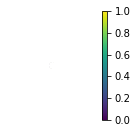

In [94]:
valid_inds = np.arange(len(names))
colors_label = [matplotlib.cm.viridis(labels[i]) for i in valid_inds]
plt.figure(figsize=(2, 2))
plt.scatter([0] * len(colors_label), [0] * len(colors_label), s=20, color=colors_label)
plt.scatter([0], [0], s=50, color=['w'])
plt.axis('off')
plt.colorbar()
plt.savefig('figs/fig-emb/label_cbar.pdf', bbox_inches='tight')

1
2
3
4
5
6
7
8
9
10
11


C:\Users\zhenq\AppData\Local\Temp/ipykernel_8208/2633417650.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5, 5))


12


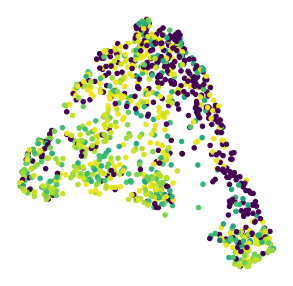

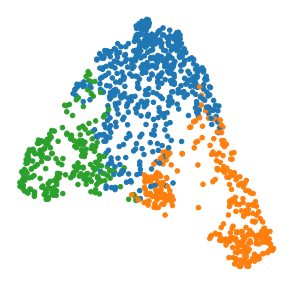

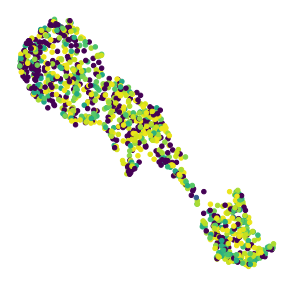

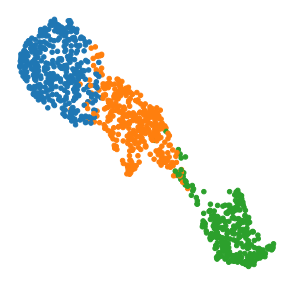

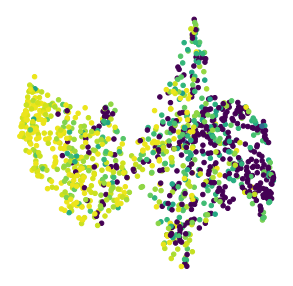

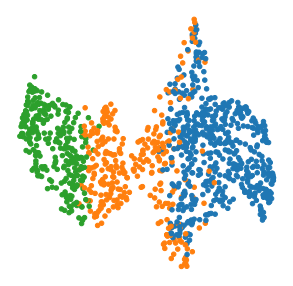

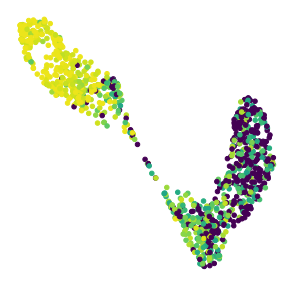

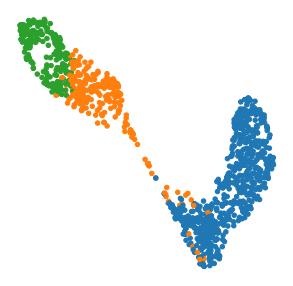

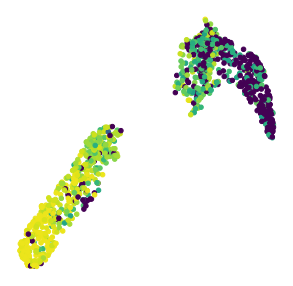

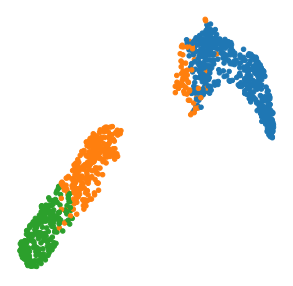

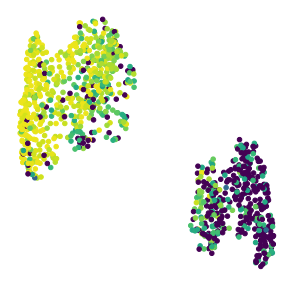

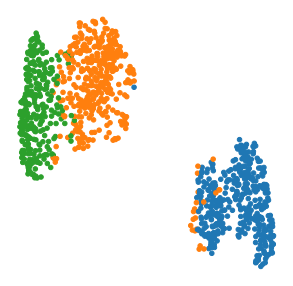

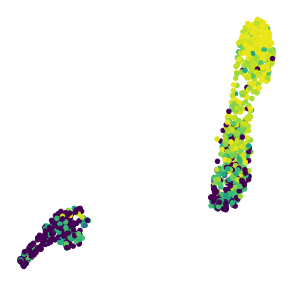

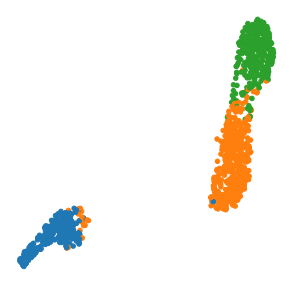

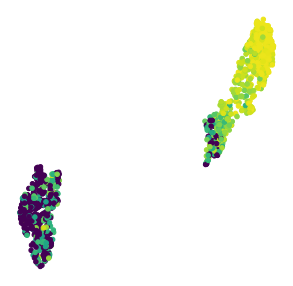

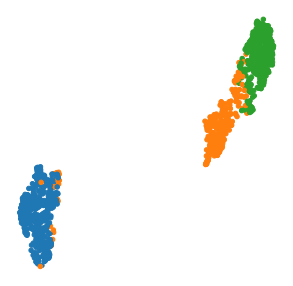

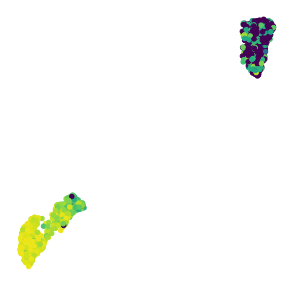

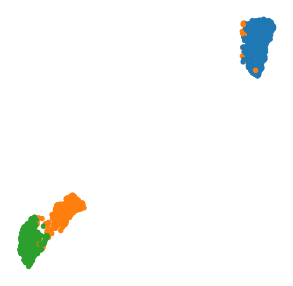

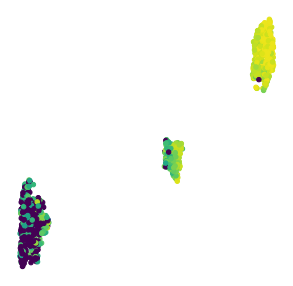

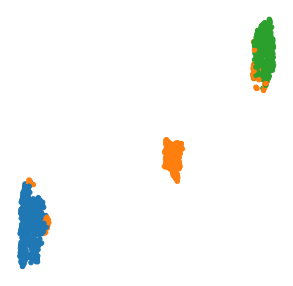

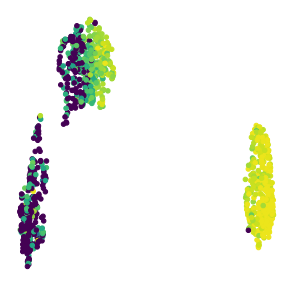

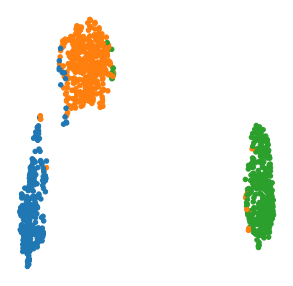

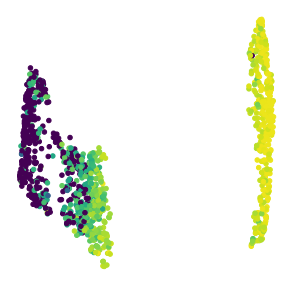

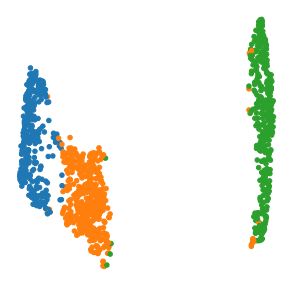

In [64]:
for _d in np.arange(1, 13):
    print(_d)
    valid_inds = np.arange(len(names))
    valid_inds = [i for i, d in enumerate(days) if d == _d]

    um = umap.UMAP(n_neighbors=20)
    _um = um.fit_transform(_emb[valid_inds])

    _km = KMeans(n_clusters=3)
    _km.fit_transform(_emb[valid_inds])
    
    km_label_mapping = {i: np.array(labels)[valid_inds][np.where(_km.labels_ == i)].mean() for i in range(3)}
    km_color_ordering = sorted(km_label_mapping.keys(), key=lambda x: km_label_mapping[x])


    valid_days = [days[i] for i in valid_inds]
    colors_day = np.array([matplotlib.cm.viridis(np.clip((days[i]-4)/8, 0., 1.)) for i in valid_inds])
    colors_label = np.array([matplotlib.cm.viridis(labels[i]) for i in valid_inds])
    colors_pred = np.array([matplotlib.cm.viridis(preds[i]) for i in valid_inds])
    colors_cluster = np.array([matplotlib.cm.tab10(km_color_ordering.index(i)) for i in _km.labels_])

    plot_inds = np.arange(len(valid_inds))
    np.random.shuffle(plot_inds)

    plt.figure(figsize=(5, 5))
    plt.scatter(_um[plot_inds][:, 0], _um[plot_inds][:, 1], color=colors_label[plot_inds], s=20)
    plt.axis('off')
    plt.savefig("figs/fig-emb/day%d-label.pdf" % _d)
    
    plt.figure(figsize=(5, 5))
    plt.scatter(_um[plot_inds][:, 0], _um[plot_inds][:, 1], color=colors_cluster[plot_inds], s=20)
    plt.axis('off')
    plt.savefig("figs/fig-emb/day%d-km.pdf" % _d)
    